In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.units import units
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from metpy import constants

from skimage.measure import label, regionprops

phys_table = [1,2,7,8,13,14, 3,4,9,10,15,16, 5,6,11,12,17,18]

#                 YSU              MYJ              MYNN

phys_table = [x-1 for x in phys_table]

print(phys_table)

storm_size = [10, 120]

lats = [35.294243, 43.726334]
lons = [-92.01535, -80.48016]


[0, 1, 6, 7, 12, 13, 2, 3, 8, 9, 14, 15, 4, 5, 10, 11, 16, 17]


In [2]:
import datetime
#--------------------------------------------------------------------------------------------------
# my datetime stuff
def my_datetime(input: list, time_delta=None, format=None, summary_file=False):

    """
        Inputs: input (list) list of [YY, MM, DD, HH, MM, SS]

                time_delta: (list)  -> [hours, minutes, seconds]
                                
                                or
                                    ->  [Days, hours, minutes, seconds]
                                    
                format:  (string)   ->  '%Y-%m-%d::%H-%M'
                
                                or
                                    ->  '%Y%d_%H%M'  (usefull for WoFS files)

        returns:  Datetime object or string if format is supplied.
        
    """
    try:
        hhmm = datetime.datetime(*input)
    except ValueError:
        print(f"Input is invalid, need YYMMDDHHMM {input}")
        return None
        
    if time_delta == None:
        
        if format == None:
            return hhmm
        else:
            return hhmm.strftime(format)
    
    else:
        
        if len(time_delta) == 3:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2])
        else:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2], seconds=time_delta[3])
            
        if format == None and summary_file == False:
            
            return hhmm + timeD
            
        else:
            
            if summary_file:

                return f"{hhmm.strftime('%Y%m%d_%H%M')}_{(hhmm+timeD).strftime('%H%M')}"

            else:  
                return (hhmm+timeD).strftime(format)

print( my_datetime([2024,5,7,19], time_delta=[0,0,65]) )
print( my_datetime([2024,5,7,19], time_delta=[0,0,65], summary_file=True ))

2024-05-07 20:05:00
20240507_1900_2005


In [40]:
# New section to "count" storms

def get_counts(ds, ens, cref_thresh =[25,], storm_size = storm_size, field_name='comp_dz'):

    if ens == 1:

        count   = np.zeros( (len(cref_thresh),), dtype='int')
        regions = np.zeros( (len(cref_thresh),), dtype='int')

        for m, cref in enumerate(cref_thresh):

            mask_cref = np.where(ds[field_name] >= cref, True, False)
    
            f_mask = mask_cref.astype(np.int8)

            mpas_label_array, count[m] = label(f_mask, connectivity=2, return_num = True)
            
            # Calculate region properties
            
            reg = regionprops(mpas_label_array)

            for region in reg:
                if region.area >= storm_size[0] and region.area <= storm_size[1]:
                    regions[m] += 1        
    else:
            
        count   = np.zeros( (len(cref_thresh), ens,), dtype='int')
        regions = np.zeros( (len(cref_thresh), ens,), dtype='int')
        
        for m, cref in enumerate(cref_thresh):

            mask_cref = np.where(ds[field_name] > cref, True, False)
    
            f_mask = mask_cref.astype(np.int8)

            for n in np.arange(ens):
                mpas_label_array, count[m,n] = label(f_mask[n], connectivity=2, return_num = True)

                # Calculate region properties
                reg = regionprops(mpas_label_array)
                for region in reg:
                    if region.area >= storm_size[0] and region.area <= storm_size[1]:
                        regions[m,n] += 1         


    return count, regions


In [35]:
def plot_counts(runs, dt_string, title, ens=18, nstep=25, skip=3, cref_thresh=[25,], plot_mrms=None):
                
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,5))

    counts  = np.zeros((len(runs), ens, nstep), dtype='int')
    regions = np.zeros((len(runs), ens, nstep), dtype='int')

    time = 5*np.arange(nstep)

    for r, run in enumerate(runs):
    
        print(f"Now computing stats for {run[0]}\n")
        
        for n in np.arange(nstep):
    
            min = int(n*5)
        
            file_string = my_datetime(dt_string, time_delta=[0,0,min], summary_file=True)
        
        # MPAS
            
            ds = xr.open_dataset(os.path.join(run[0], f"wofs_ALL_{n:02}_{file_string}.nc"))
        
            the_count, the_region = get_counts(ds, ens, cref_thresh = cref_thresh)

            counts[r,:,n]  = the_count[0,phys_table]
            regions[r,:,n] = the_region[0,phys_table]
                
            ds.close()
        
        # axs[2].plot(time[skip:], counts[r,:,skip:].sum(axis=(0)), color=run[2], label=run[1])

        axs[0].plot(time[skip:], regions[r,:,skip:].sum(axis=(0)), color=run[2], label=run[1])
        
        # reorder the array to isolate PBL

        axs[1].plot(np.arange(ens), regions[r,:,skip:].sum(axis=1), color=run[2], label=run[1])

    if plot_mrms:

        with open(plot_mrms, 'rb') as file:
            data = pickle.load(file)
            
        axs[0].plot(data['time'], data['objects'], linestyle='--', color='k', label='MRMS')
        axs[1].hlines(xmin=0, xmax=17, y=data['objects'].mean(), linestyle='--', color='k', label='MRMS')

    # axs[2].set_title(title, fontsize=10)
    # axs[2].set_xlabel('Forecast time in minutes')
    # axs[2].set_ylabel('Pixel Count')
    # axs[2].set_ylim(1000,3000)
    # axs[2].legend();

    axs[0].set_title(title, fontsize=10)
    axs[0].set_xlabel('Forecast time in minutes')
    axs[0].set_ylabel(f'OBJ SIZE MIN:{storm_size[0]}  MAX:{storm_size[1]}')
    axs[0].set_ylim(0,2000)
    axs[0].legend();

    axs[1].set_title(title, fontsize=10)
    axs[1].set_xlim(0,17)
    axs[1].set_ylim(0000,2000)
    yrange = axs[1].get_ylim()
    axs[1].vlines(x=5,  ymin=yrange[0], ymax=yrange[1], colors='k', alpha = 0.25)
    axs[1].vlines(x=11, ymin=yrange[0], ymax=yrange[1], colors='k', alpha = 0.25)
    new_ticks  = [3, 8, 13]
    new_labels = ['YSU', 'MYJ', 'MYNN']
    axs[1].set_xticks(new_ticks)
    axs[1].set_xticklabels(new_labels)
    axs[1].set_xlabel('ENS MEMBERS')
    axs[1].set_ylabel(f'TOTAL OBJS with MIN:{storm_size[0]}  MAX:{storm_size[1]}')
    axs[1].legend()


    return counts, regions

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmRTPS/1900

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900



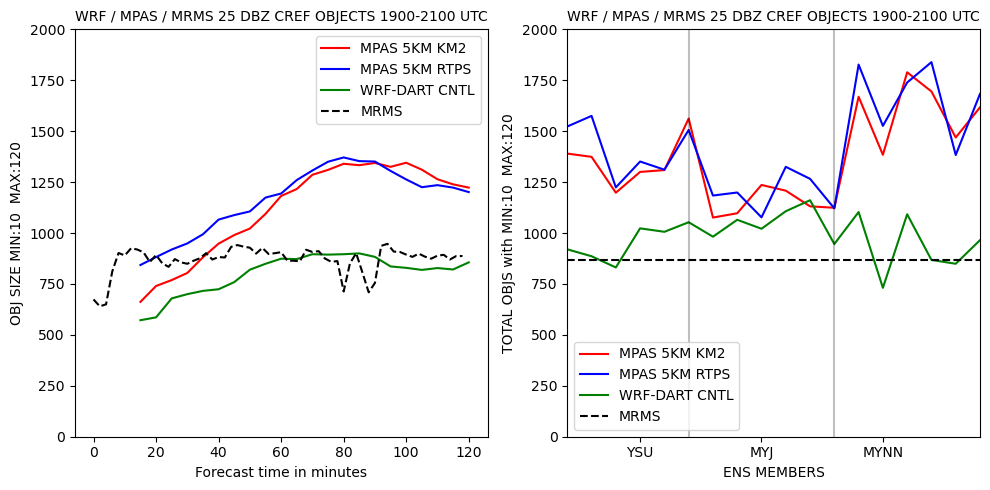

In [5]:
nstep = 25
ens   = 18
cref_thresh = [25,]

runs  = [
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900','MPAS 5KM KM2', 'r'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmRTPS/1900','MPAS 5KM RTPS', 'b'],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900', 'WRF-DART CNTL', 'g']
        ]

title = f"WRF / MPAS / MRMS {cref_thresh[0]} DBZ CREF OBJECTS 1900-2100 UTC"

dt_string = [2024,5,7,19]

counts1 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, cref_thresh=cref_thresh, plot_mrms='./mrms1900.pickle')

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2000

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmRTPS/2000

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000



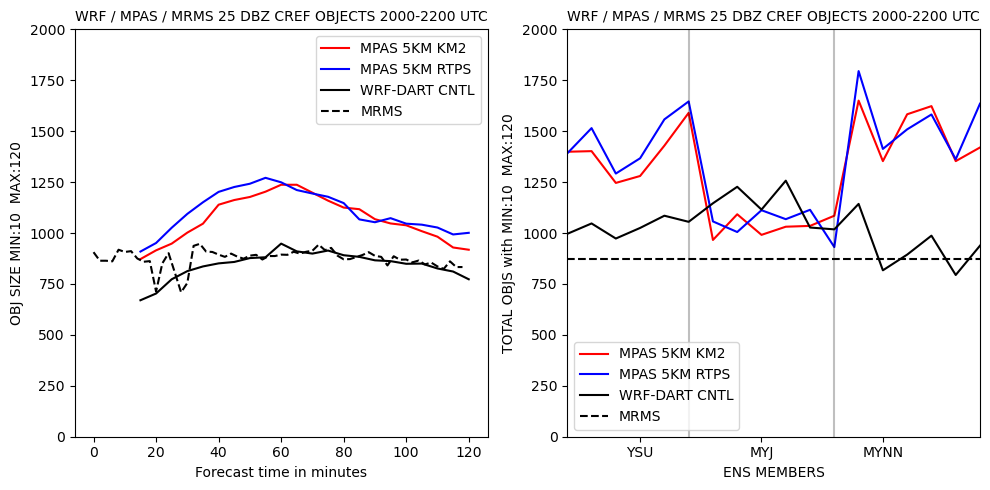

In [155]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18

runs  = [
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2000','MPAS 5KM KM2', 'r'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmRTPS/2000','MPAS 5KM RTPS', 'b'],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000', 'WRF-DART CNTL', 'k']
        ]

title = f"WRF / MPAS / MRMS {cref_thresh[0]} DBZ CREF OBJECTS 2000-2200 UTC"

dt_string = [2024,5,7,20]
counts2 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, cref_thresh=cref_thresh, plot_mrms='./mrms2000.pickle')

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2100

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmRTPS/2100

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100



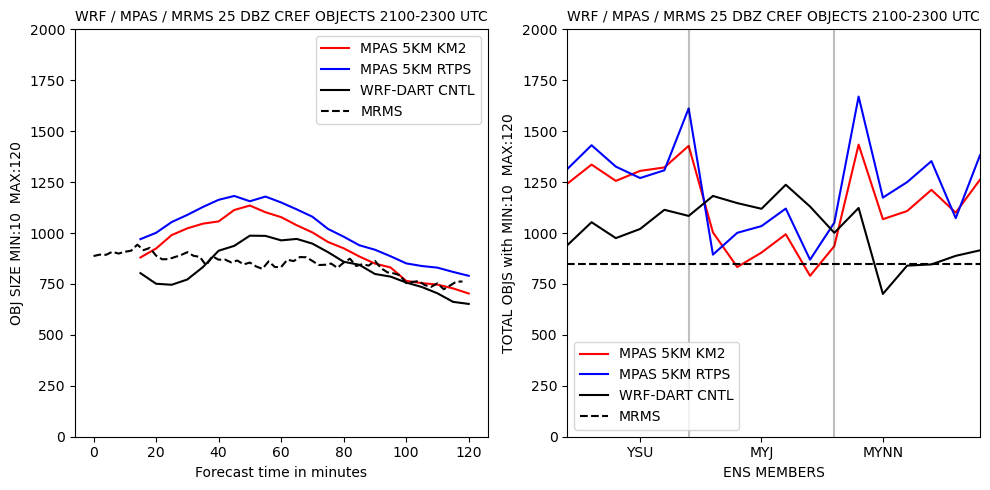

In [156]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18

runs  = [
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2100','MPAS 5KM KM2', 'r'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmRTPS/2100','MPAS 5KM RTPS', 'b'],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100', 'WRF-DART CNTL', 'k']
        ]

title = f"WRF / MPAS / MRMS {cref_thresh[0]} DBZ CREF OBJECTS 2100-2300 UTC"

dt_string = [2024,5,7,21]
counts3 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, cref_thresh=cref_thresh, plot_mrms='./mrms2100.pickle')

ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


In [6]:
def get_sorted_files(directory, pattern):
  """
  Gets a list of files in a directory matching a wildcard pattern, 
  sorts them alphabetically, and returns the sorted list.

  Args:
    directory: The path to the directory to search.
    pattern: The wildcard pattern to match (e.g., "*.txt", "image*").

  Returns:
    A list of sorted file names that match the pattern, or an empty list if 
    no files match or the directory doesn't exist.
  """
  try:
    file_paths = glob.glob(os.path.join(directory, pattern))
    sorted_files = sorted(file_paths)
    return sorted_files
  except FileNotFoundError:
    return []



Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240507/2100/MRMS_MergedReflectivityQComposite_00.50_20240507-210042.grib2



ValueError: setting an array element with a sequence.

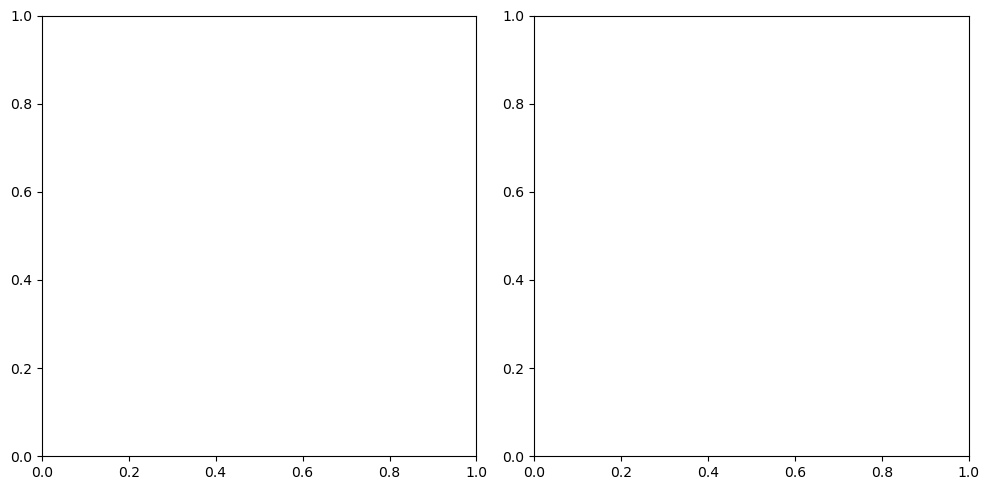

In [41]:
# MRMS

directory = "/work/wicker/MPAS_WRF_W/MRMS_20240507/2100/"
pattern    = "MRMS_MergedReflectivityQComposite_00.50_20240507-*.grib2"

files = get_sorted_files(directory, pattern)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,5))

nstep = len(files)
dt    = 120 / nstep

time = dt*np.arange(nstep)

mrms_counts  = np.zeros((nstep,), dtype='int')
mrms_regions = np.zeros((nstep,), dtype='int')

for n, file in enumerate(files):

    if (n % 10 ) == 0:
        print(f"Now computing stats for {file}\n")
            
    ds = xr.open_dataset(file, engine='cfgrib')

    cropped_ds = ds.sel(latitude=slice(lats[1],lats[0]), longitude=slice(lons[0]+360,lons[1]+360))

    cropped_ds2 = cropped_ds.coarsen(latitude=3,boundary='trim').mean().coarsen(longitude=3,boundary='trim').mean()
    
    the_count, the_region = get_counts(cropped_ds2, 1, storm_size=None, field_name = 'unknown', cref_thresh = [25,])

    mrms_counts[n]  = the_count[0]
    mrms_regions[n] = the_region[0]
        
    ds.close()
    
axs[0].plot(time, mrms_counts, color='k', label="MRMS")

axs[1].plot(time, mrms_regions, color='k', label="MRMS")

# reorder the array to isolate PBL

axs[0].set_title('MRMS', fontsize=10)
axs[0].set_xlabel('Time in minutes')
axs[0].set_ylabel('Pixel Count')
axs[0].set_ylim(000,1000)
axs[0].legend();

axs[1].set_title('MRMS', fontsize=10)
axs[1].set_xlabel('Time in minutes')
axs[1].set_ylabel(f'OBJ SIZE MIN:{storm_size[0]}  MAX:{storm_size[1]}')
axs[1].set_ylim(0,500)
axs[1].legend();


In [30]:
mrms_data = {'time': time, 'pixels': mrms_counts, 'objects': mrms_regions}

# Pickling (serialization)
with open('mrms2100.pickle', 'wb') as file:
    pickle.dump(mrms_data, file)


In [37]:
mrms_regions

array([104, 101, 102, 102,  99,  91,  91,  94,  95,  90,  97, 106,  96,
       103,  98,  97, 101,  93,  93,  84,  88,  90,  91,  88,  96,  97,
        92,  94,  98,  92,  85, 100,  95,  98, 103, 104, 105, 101, 105,
        99, 102,  94,  87,  91,  85,  81,  93,  90,  88,  79,  76,  78,
        80,  74,  81,  81,  87,  83,  89,  93])

(array([ 2.,  3.,  4.,  3.,  6., 13.,  7.,  8.,  7.,  7.]),
 array([ 74. ,  77.2,  80.4,  83.6,  86.8,  90. ,  93.2,  96.4,  99.6,
        102.8, 106. ]),
 <BarContainer object of 10 artists>)

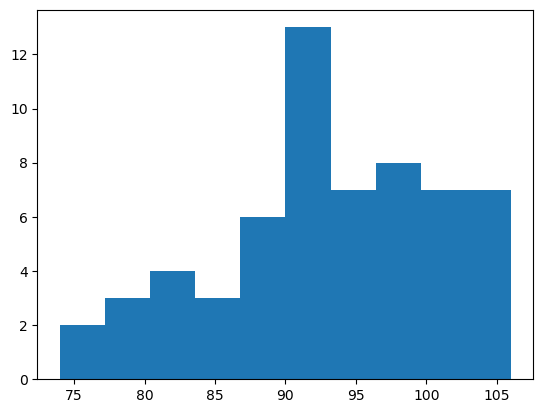

In [32]:
plt.hist(mrms_regions)

In [17]:
print(ds.XLAT.max())
print(ds.XLAT.min())
print(ds.XLONG.max())
print(ds.XLONG.min())

<xarray.DataArray 'XLAT' ()> Size: 4B
array(43.726334, dtype=float32)
<xarray.DataArray 'XLAT' ()> Size: 4B
array(35.294243, dtype=float32)
<xarray.DataArray 'XLONG' ()> Size: 4B
array(-80.48016, dtype=float32)
<xarray.DataArray 'XLONG' ()> Size: 4B
array(-92.01535, dtype=float32)


In [26]:
print(lons)

[-92.01535, -80.48016]
